**Author:** [Martina Cinquini](http://pages.di.unipi.it/cinquini/)  
**Python version:**  3.8 <br>
**Last update:** 11/25/21

# **NCDA** - **N**onlinear **C**ausal **D**iscovery with **Apriori**

### Table of Contents

* [Introduction to Causal Discovery (CD)](#section1)
    * [Nonlinear CD with Additive Noise Models (NCD)](#section_1_1)
        * [Case 1: Bivariate Data](#section_1_1_1)
        * [Case 2: Multivariate Data](#section_1_1_2)
    * [Example Case 1](#section_1_2_1)
    * [Example Case 2](#section_1_2_2)
    * [Pros & Cons](#section_1_3)
* [Nonlinear CD with Apriori (NCDA)](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)
    * [Section 1.2.3](#section_1_2_3)

### Introduction to Causal Discovery <a class="anchor" id="section1"></a>

Given a dataset $X$, the objective of causal discovery is to infer as much as possible about the mechanism generating the data. In particular, the goal is to discover the graph $G$ modeling the dependencies among variables.
<br><br>
<div>
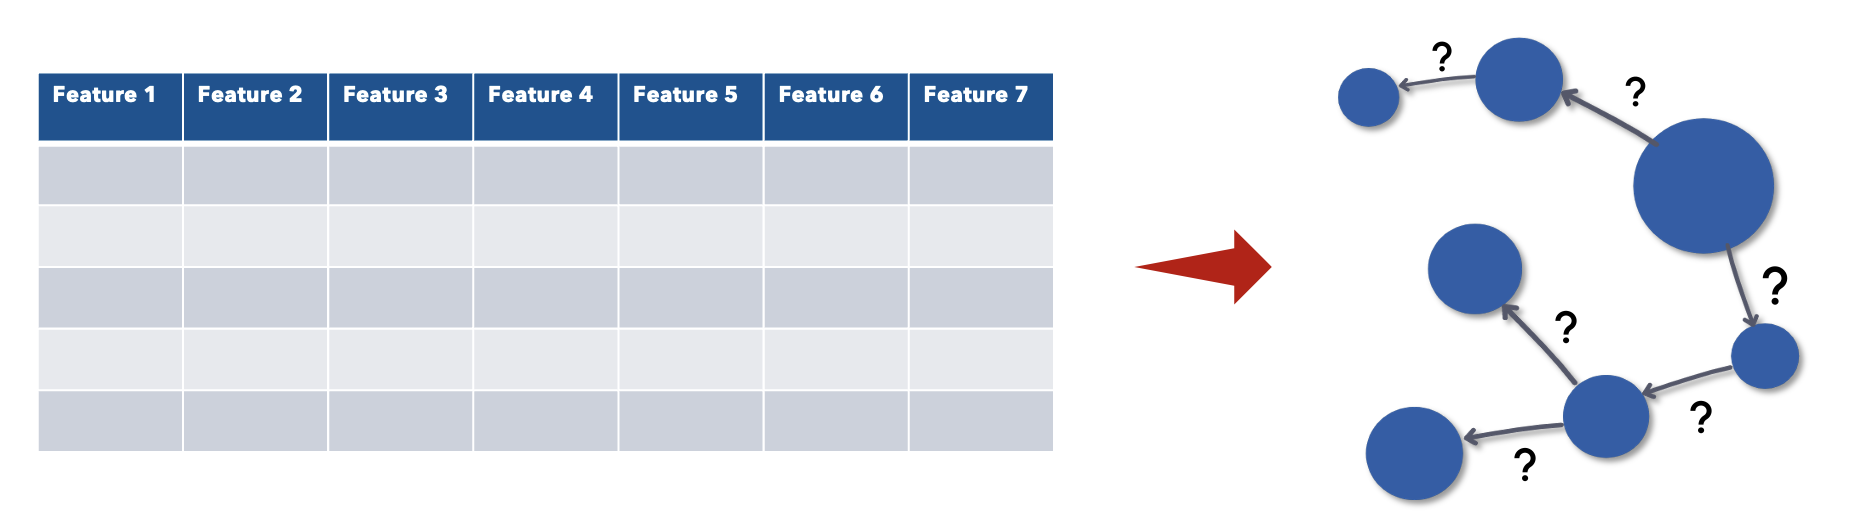
</div>

#### Nonlinear CD with additive noise models<a class="anchor" id="section1_1"></a>
As starting point for our project we adopt a specific procedure called [Nonlinear Causal Discovery (NCD)](https://papers.nips.cc/paper/2008/file/f7664060cc52bc6f3d620bcedc94a4b6-Paper.pdf) originally proposed by
Hoyer et al. that demonstrates that nonlinearities in the data generation process allow more accurate information of the causal system to be identified.

They assume that the observed data has been generated in the following way:
<br>
each feature $x^{(j)}$ is associated with a node $j$ in $G$, and the values of $x^{(j)}$ are obtained as a function of its parents in $G$, plus some independent additive noise $\nu^{(j)}$, i.e., <br>
<br>
\begin{equation}
\label{eq:hoyer}
    x^{(j)} = f_j(\mathit{pa}(j)) + \nu^{(j)}
\end{equation}
<br>
where $f_j$ is an arbitrary function (possibly different for each $j$), $\mathit{pa}(j)$ is a vector containing the elements $x^{(j)}$ such that there is an edge from $i$ to $j$ in $G$, i.e., $\mathit{pa}(j)$ returns the parents of $j$.

#### Case 1: Bivariate Data<a class="anchor" id="section1_1_1"></a>

We now consider practical estimation method which infer the generating graph from sample data. 

1) Test whether x and y are statistically independent. 
<br>If they are not, we continue as described in the following manner: <br> <br>
2) Test whether a model $y:=f(x) + n$ is consistent with the data <br>
    - By doing a nonlinear regression of y on x (to get an estimate $\hat{f}$ of $f$) <br>
    - Calculating the corresponding residuals $\hat{n} = y − f(x)$ <br>
    - Testing whether $\hat{n}$ is independent of x. <br> <br>
3) If $\hat{n}$ is independent of x, we accept the model $y := f(x) + n$; if not, we reject it. <br>

4) We then similarly test whether the reverse model $x := g(y) + n$ fits the data.

#### Case 2: Multivariate Data<a class="anchor" id="section1_1_2"></a>

For each DAG, test whether it is consistent with the data by constructing a **nonlinear regression of each variable on its parents** and subsequently testing whether the **resulting residuals are mutually independent**. <br> <br>
The DAG is accepted only **if none of the independence tests are rejected**. 

### Example Case 1 - Abalone Dataset<a class="anchor" id="section1_2_1"></a>

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from time import time
import networkx as nx

Let's analyze a possible application of the methodology. The object of investigation is an open-source dataset from the UCI repository concerning the [abalone](https://archive.ics.uci.edu/ml/datasets/abalone), a group of shellfish.

In [2]:
directory = os.path.realpath(os.path.dirname("GENCDA"))
file_path = os.path.join(os.path.dirname(directory), "datasets", "abalone.csv")
dataset = pd.read_csv(file_path) # Abalone Data
df = dataset.sample(500) # Sample of 500 instances
df.head()

,Rings,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
2701,13,0.675,0.550,0.190,1.5510,0.7105,0.3685,0.412
1753,10,0.720,0.570,0.200,1.8275,0.9190,0.3660,0.485
4166,10,0.475,0.365,0.115,0.4990,0.2320,0.0885,0.156
414,14,0.605,0.495,0.170,1.2385,0.5280,0.2465,0.390
3307,9,0.450,0.325,0.135,0.4380,0.1805,0.1165,0.110


Ground Truth


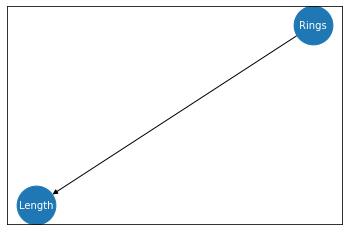

In [3]:
graph = nx.DiGraph()
graph.add_edges_from([('Rings', 'Length')])
print('Ground Truth')
nx.draw_networkx(graph, node_size=1500, font_color='w', font_size=10)

Specifically, variables considered are:
* The number of rings in the abalone shell that indicate their age
* The length of the shell

In [4]:
from causal_discovery.hoyer import *

In [5]:
# To run causal discovery, we create a NonlinearANM object                                                                                          1e-10, 1e+1))
obj = NonlinearANM(df) 

index_rings = 0
index_length = 1

# We specify the covariance function of the regressor
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Finally, we call the fit method for the case of two variables 
p_value_general, p_value_fm, p_value_bm = obj.fit_bivariate(index_rings, index_length, kernel=kernel)

In [6]:
obj.evaluate(p_value_general, p_value_fm, p_value_bm)

Neither direction is consistent with the data so the generating mechanism cannot be described using this model.


Forward Model (Rings , Length)


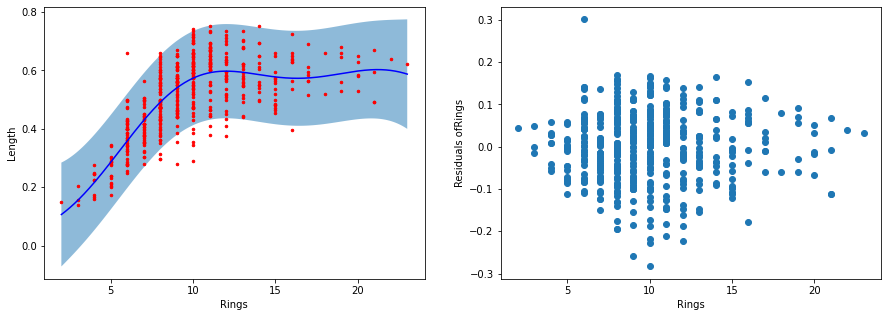

Backward Model (Length , Rings)


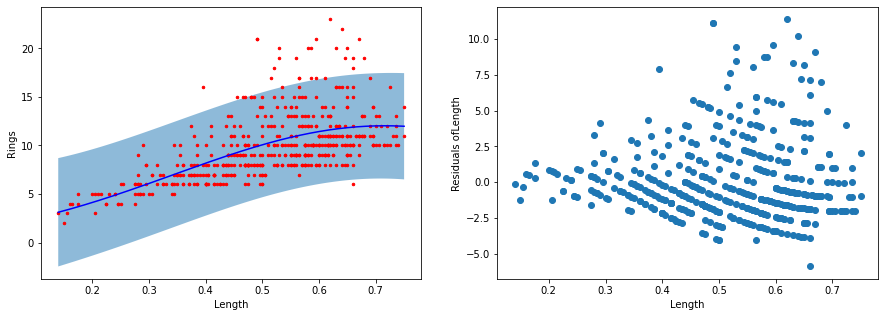

In [7]:
obj.show_plots()

### Example Case 2 - Synthetic Dataset<a class="anchor" id="section1_2_2"></a>

In [8]:
# Experiment on synthetic data used in the paper
np.random.seed(1)
n = 1000
n_x = uniform(-1, 1, n)
n_y = uniform(-1, 1, n)
n_z = uniform(-1, 1, n)
w = uniform(-3, 3, n)
x = w ** 2 + n_x
y = 4 * np.sqrt(np.absolute(w)) + n_y
z = 2 * np.sin(x) + 2 * np.sin(y) + n_z

matrix = np.column_stack((w, x, y, z))
feature_names = ['w', 'x', 'y', 'z']

synthetic_data = pd.DataFrame(matrix, columns=feature_names)

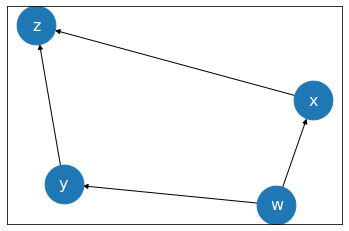

In [9]:
"""
Ground Truth 

['w' --> 'x', 'w' --> 'y', 'x' --> 'z', 'y' --> 'z']

"""
graph = nx.DiGraph()
graph.add_nodes_from(['w', 'y', 'x', 'z'])
graph.add_edges_from([('w', 'x'), ('w', 'y'), ('x', 'z'), ('y', 'z')])
nx.draw_networkx(graph, node_size=1500, font_color='w', font_size=16)

In [10]:
# We create a NonlinearANM object
obj2 = NonlinearANM(synthetic_data)

# Parameters of the fit_multivariate method
alpha = 0.02
percentage_split = 0.7
dag_sorting_type = np.min

start_time = time()

possible_dags = obj2.fit_multivariate(alpha, percentage_split, dag_sorting_type)

nonlinearANM_execution_time = time() - start_time


In [11]:
ordered_result = sorted(possible_dags, key=itemgetter(1), reverse=True)

In [12]:
res = []
for adj_matrix, p_value in possible_dags:
    res.append(adj_matrix)
show_dependency(res, feature_names)

Causal dependence n: 0
['y'] --> z
Causal dependence n: 1
['x', 'y'] --> z
Causal dependence n: 2
['w'] --> z
Causal dependence n: 3
['w', 'y'] --> z
Causal dependence n: 4
['w'] --> y
Causal dependence n: 5
['w', 'z'] --> y
Causal dependence n: 6
['w'] --> y
['y'] --> z
Causal dependence n: 7
['w'] --> y
['x', 'y'] --> z
Causal dependence n: 8
['w', 'x'] --> y
Causal dependence n: 9
['w', 'x'] --> y
['y'] --> z
Causal dependence n: 10
['w', 'x'] --> y
['x', 'y'] --> z
Causal dependence n: 11
['w'] --> y
['w'] --> z
Causal dependence n: 12
['w', 'z'] --> y
['w'] --> z
Causal dependence n: 13
['w'] --> y
['w', 'y'] --> z
Causal dependence n: 14
['w', 'x'] --> y
['w'] --> z
Causal dependence n: 15
['w', 'x'] --> y
['w', 'y'] --> z
Causal dependence n: 16
['w'] --> x
Causal dependence n: 17
['w', 'z'] --> x
Causal dependence n: 18
['w'] --> x
['y'] --> z
Causal dependence n: 19
['w', 'z'] --> x
['y'] --> z
Causal dependence n: 20
['w', 'y'] --> x
Causal dependence n: 21
['w', 'y'] --> x
[

#### Pros & Cons<a class="anchor" id="section1_3"></a>

<div>
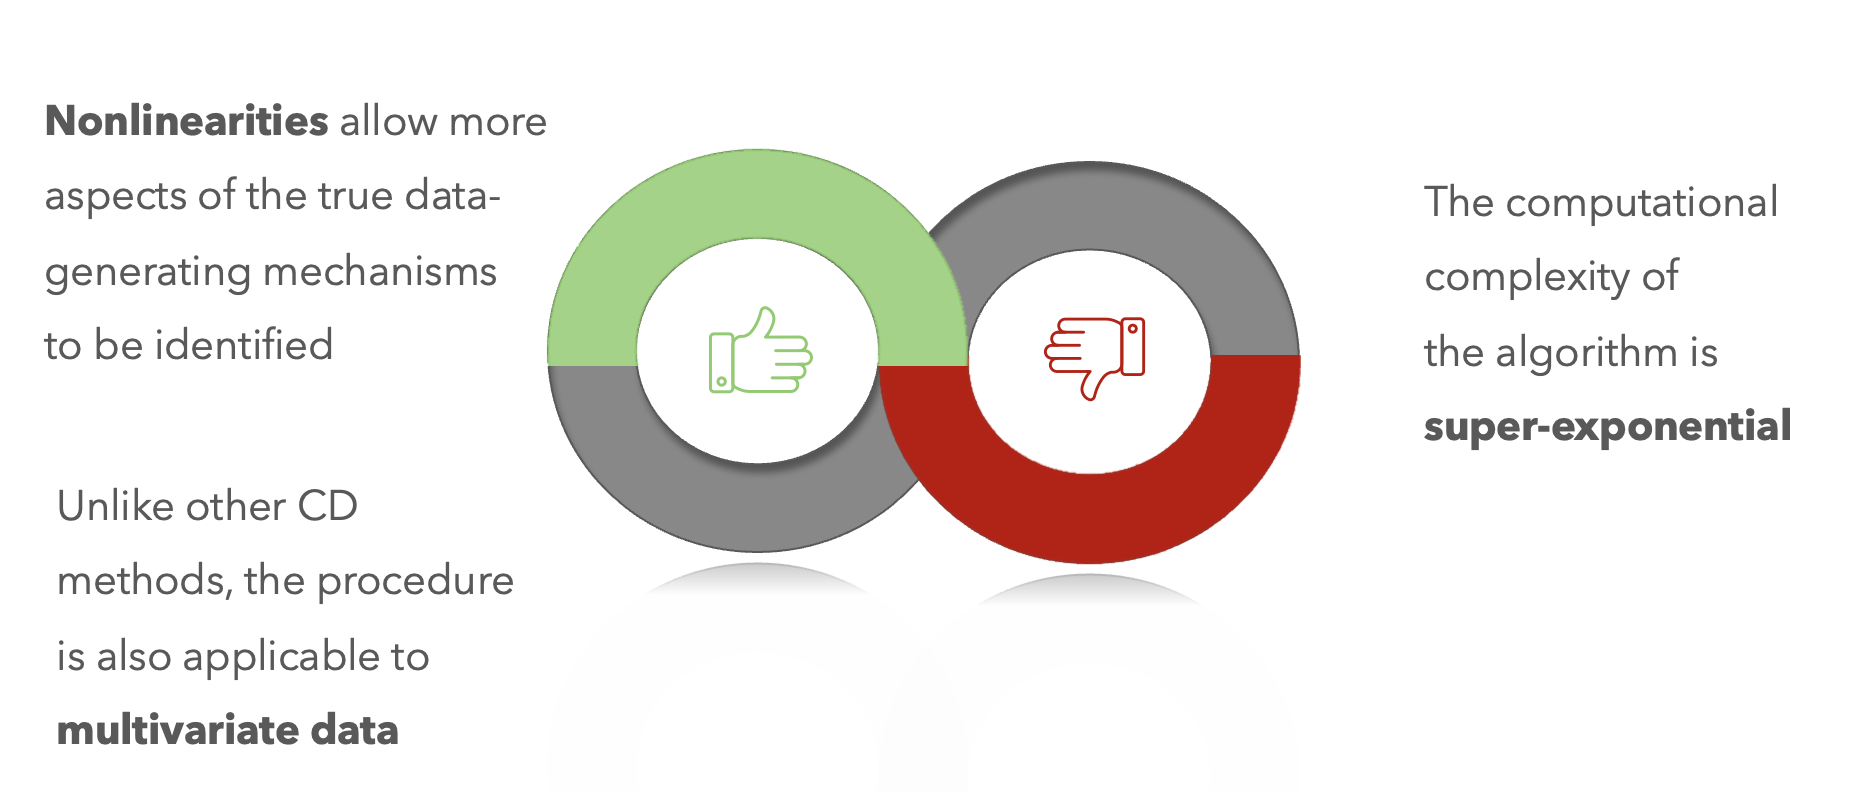
</div>

### Nonlinear Causal Discovery with Apriori (NCDA) <a class="anchor" id="section2"></a>

We propose a solution to this criticality by exploiting the Apriori algorithm. 
In particular, we use **Apriori as a filter** to reduce the number of possible combinations and to reduce the search space for NCD. For further information, check our paper. 

<div>
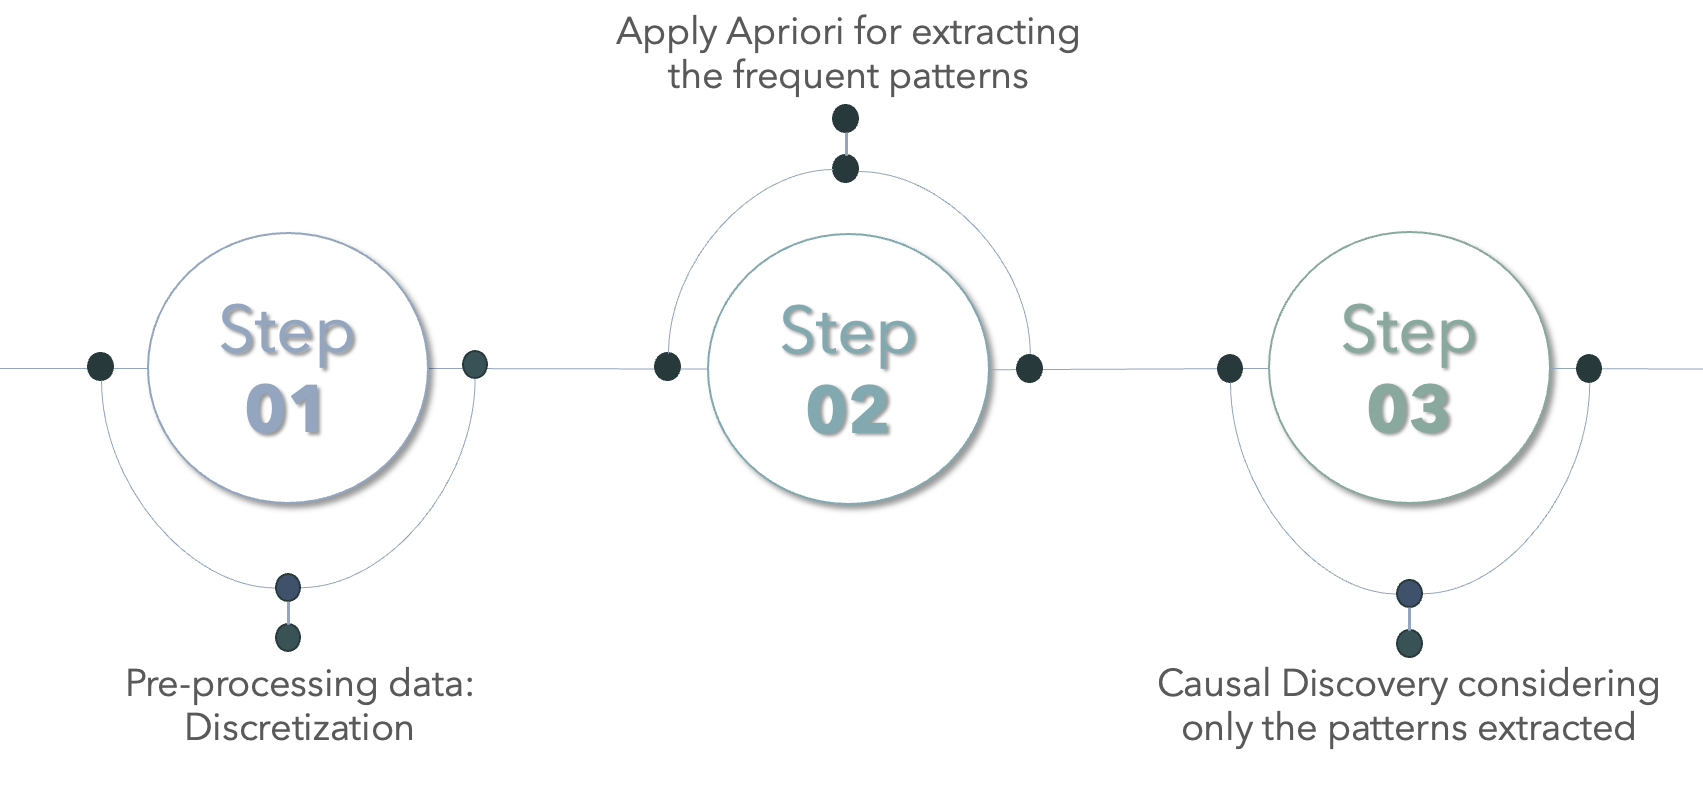
</div>

In [13]:
%load_ext autoreload
%autoreload 2
from causal_discovery.ncda import * 

### Example on Synthetic Data 

In [14]:
# Instantiate main class
ncda = NCDApriori(synthetic_data)

In [15]:
# Fit Apriori 

"""
Since our method works on continuos dataset, we discretize our dataframe to apply the pattern mining algorithm. 

"""

itemsets = ncda.fitApriori(target='m', zmax=3, nbins=4, strategy='quantile', support=5)

In [16]:
print(f'Maximal itemsets found by Apriori: \n\n{itemsets}')

Maximal itemsets found by Apriori: 

[('x', 'w', 'y'), ('x', 'w', 'z'), ('w', 'z', 'y'), ('x', 'z', 'y')]


In [17]:
"""
Evaluate the number of relations found by comparing the frequent elements found by apriori and the dag. 
In this case, we check itemsets on an indirect acyclic graph 
since directions of the arcs are not relevant.
Our objective is to know if apriori can detect all relations. (Best scenario: Recall = 1.0)

"""

ncda.evaluateRelations(graph)

{'precision': 0.6666666666666666,
 'recall': 1.0,
 'accuracy': 0.6666666666666666,
 'f1': 0.8}

In [18]:
# Fit Causal Discovery Algorithm implemented by Hoyer et al. 

start_time_ncda = time()
causal_relations = ncda.fitNCD(itemsets, alpha=0.001, sorting=np.mean, train_size=0.7, standardization=True)
ncda_execution_time = time() - start_time_ncda

causal_relations

[('y', 'z'), ('w', 'z')]

In [19]:
"""
Evaluation of the number of relations found comparing causal relationship found by NCD and the ground truth. 
In this case, we verify relations on an direct acyclic graph.
""" 

# We have to transform dag edges as strings
edges = [(str(source), str(destination)) for source, destination in graph.edges]

precision, recall, accuracy, f1 = evaluate(causal_relations, edges, graph)
print(f'Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy}\nF1: {f1}')

Precision: 0.5
Recall: 0.25
Accuracy: 0.6666666666666666
F1: 0.3333333333333333


In [22]:
def improvement(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

In [29]:
# time in seconds
nonlinearANM_execution_time, ncda_execution_time

(207.2927601337433, 30.544829845428467)

In [30]:
perc = round(improvement(ncda_execution_time, nonlinearANM_execution_time), 2)
print(f'Time execution improvement of our method NCDA w.r.t NCD: {perc}%')

Time execution improvement of our method NCDA w.r.t NCD: 85.26%
